### Part 1. Data Acquisition & Preprocessing
#### Staring with incorperating the dataset

In [1]:
%pip install kaggle -q

Note: you may need to restart the kernel to use updated packages.


In [134]:
# Importing all neccessary frameworks

import numpy as np
import torch


from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize, scale, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

#%load_ext cudf.pandas
import pandas as pd
from cuml.manifold import UMAP
from cuml.cluster import hdbscan
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

import warnings
warnings.filterwarnings('ignore')

In [3]:
%%bash
# Downloading the dataset from Kaggle

export KAGGLE_USERNAME=orranereid
export KAGGLE_KEY=395c5483c47968f4a9e8ea5ac326f64f

#kaggle datasets download -d elvinrustam/books-dataset --unzip --force

# Preproccessing Data Steps.

**Data Sources**

From Kaggle, we were able to use a Book Dataset with over 100,000 observations. It includes multiple features such as authors, genres, titles, & date of publication.

In [4]:
# Extracting the info from the CSV fiel
gb_md = pd.read_csv('BooksDataset.csv')

In [5]:
# Here we are printing the original data from the csv
gb_md

,Title,Authors,Description,Category,Publisher,Publish Date,Price
0,Goat Brothers,"By Colton, Larry",NaN,"History , General",Doubleday,"Friday, January 1, 1993",Price Starting at $8.79
1,The Missing Person,"By Grumbach, Doris",NaN,"Fiction , General",Putnam Pub Group,"Sunday, March 1, 1981",Price Starting at $4.99
2,Don't Eat Your Heart Out Cookbook,"By Piscatella, Joseph C.",NaN,"Cooking , Reference",Workman Pub Co,"Thursday, September 1, 1983",Price Starting at $4.99
3,When Your Corporate Umbrella Begins to Leak: A...,"By Davis, Paul D.",NaN,NaN,Natl Pr Books,"Monday, April 1, 1991",Price Starting at $4.99
4,Amy Spangler's Breastfeeding : A Parent's Guide,"By Spangler, Amy",NaN,NaN,Amy Spangler,"Saturday, February 1, 1997",Price Starting at $5.32
...,...,...,...,...,...,...,...
103077,Build 3 Super Serving Carts,By Chuck Hampton,NaN,NaN,ENDesigns Inc.,"Wednesday, January 1, 1992",Price Starting at $9.97
103078,My Land of Israel,"By Nover, Elizabeth Z.",NaN,"Juvenile Nonfiction , People & Places , Middl...",Behrman House,"Friday, May 1, 1987",Price Starting at $4.99
103079,Tongues: To Speak or Not to Speak,By Donald W. Burdick,NaN,NaN,Moody Press,"Wednesday, January 1, 1969",Price Starting at $5.29
103080,If I'm in charge here why is everybody laughing?,"By Campbell, David P.",NaN,NaN,Argus Communications,"Tuesday, January 1, 1980",Price Starting at $4.99


**Data Cleaning and Preprocessing**

In this step, we will remove any noisy data with inconsistencies and missing values. Then, we will modify our data by applying tokenization techniques.

In [6]:
# Dropping all observations with missing values
gb_md = gb_md.dropna()

# Now we will be dropping features that are irrelevant for us
gb_md = gb_md.drop(columns=['Price', 'Publisher'])


In [7]:
# Modifying the values in Publish Date to only keep the year
gb_md['Publish Date'] = gb_md['Publish Date'].str.slice(-4)

# Removing the value 'General' from the 'Categories' feature in order to avoid bad clusterings
gb_md['Category'] = gb_md['Category'].str.replace('General', '', regex=False)
gb_md['Category'] = gb_md['Category'].str.strip()
gb_md = gb_md[gb_md['Category'] != '']
gb_md['Category'] = gb_md['Category'].str.rstrip(',')

# Removing "By" in the Authors Column
gb_md['Authors'] = gb_md['Authors'].str.replace('^By ', '', regex=True)


In [8]:
# Demonstrating the first five observations of our "clean" data
gb_md.head()

,Title,Authors,Description,Category,Publish Date
7,Journey Through Heartsongs,"Stepanek, Mattie J. T.",Collects poems written by the eleven-year-old ...,Poetry,2001
8,In Search of Melancholy Baby,"Aksyonov, Vassily, Heim, Michael Henry, and Bo...",The Russian author offers an affectionate chro...,Biography & Autobiography,1987
10,The Dieter's Guide to Weight Loss During Sex,"Smith, Richard","A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets",1978
11,Germs : Biological Weapons and America's Secre...,"Miller, Judith, Engelberg, Stephen, and Broad,...","Deadly germs sprayed in shopping malls, bomb-l...","Technology & Engineering , Military Science",2001
13,The Good Book: Reading the Bible with Mind and...,"Gomes, Peter J.","""The Bible and the social and moral consequenc...","Religion , Biblical Biography",1998


In [9]:
df = gb_md[52000:65000]

In [10]:
df.head()

,Title,Authors,Description,Category,Publish Date
81173,Pillsbury: Best Muffins and Quick Breads: Favo...,Pillsbury Company,The latest addition to the best-selling cookin...,Cooking,1999
81175,Ross's Gap,"Wisler, G. Clifton",Returning home from the Civil War to reclaim h...,"Fiction , Westerns",1999
81176,"Across the Nightingale Floor, Episode 1: The S...","Hearn, Lian","In a novel set in ancient Japan, the first vol...","Young Adult Fiction , Historical , Asia",2005
81178,Ideas for Great Bathrooms,Sunset Books (EDT),Shows and describes some contemporary bathroom...,"House & Home , Remodeling & Renovation",1999
81179,Stanley and the Magic Lamp,"Bjorkman, Steve (ILT) and Brown, Jeff",The Lambchop family has just about recovered f...,Juvenile Fiction,1996


In [11]:
#Combining the columns description + category which should capture semantics of genre and their summaries
text_data = df['Title']+ ': ' + df['Description'] + ": " + df['Category']

# Initializing our tokenizer from the transformers model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# Also initializing our pre-trained LLM --> BERT
book_model = AutoModel.from_pretrained("bert-base-uncased")

In [12]:
print(torch.cuda.is_available())

True


In [13]:
book_model = book_model.to('cuda')

def get_embeddings_for_chunk(chunk):
    tokenized_inputs = tokenizer(
        chunk,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512  # Ensure truncation for long texts
    ).to('cuda')  # Move to GPU
    outputs = book_model(**tokenized_inputs)
    hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_dim)
    embeddings = hidden_states.mean(dim=1)  # Mean pooling across tokens
    return embeddings.detach().cpu().numpy()  # Move to CPU before converting to numpy


In [14]:
# Define batch size
batch_size = 24  # Adjust based on available memory

# Process dataset in chunks to avoid memory overload
num_chunks = len(df) // batch_size + 1  # Total chunks based on batch size
all_embeddings = []
for i in range(num_chunks):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df))

    # Retry mechanism for out-of-memory
    while True:
        try:
            chunk = text_data[start_idx:end_idx].tolist()
            embeddings_chunk = get_embeddings_for_chunk(chunk)
            if i % 10 == 0 or num_chunks - i < 10:
                print(f'Chunk {i} of {num_chunks}') 
            break
        except RuntimeError as e:
            if "out of memory" in str(e):
                batch_size //= 2  # Halve the batch size
                torch.cuda.empty_cache()  # Clear GPU memory
            else:
                raise e
    all_embeddings.append(embeddings_chunk)
    


# Combine all chunks into a single list of embeddings
all_embeddings = np.vstack(all_embeddings)


Chunk 0 of 542
Chunk 10 of 542
Chunk 20 of 542
Chunk 30 of 542
Chunk 40 of 542
Chunk 50 of 542
Chunk 60 of 542
Chunk 70 of 542
Chunk 80 of 542
Chunk 90 of 542
Chunk 100 of 542
Chunk 110 of 542
Chunk 120 of 542
Chunk 130 of 542
Chunk 140 of 542
Chunk 150 of 542
Chunk 160 of 542
Chunk 170 of 542
Chunk 180 of 542
Chunk 190 of 542
Chunk 200 of 542
Chunk 210 of 542
Chunk 220 of 542
Chunk 230 of 542
Chunk 240 of 542
Chunk 250 of 542
Chunk 260 of 542
Chunk 270 of 542
Chunk 280 of 542
Chunk 290 of 542
Chunk 300 of 542
Chunk 310 of 542
Chunk 320 of 542
Chunk 330 of 542
Chunk 340 of 542
Chunk 350 of 542
Chunk 360 of 542
Chunk 370 of 542
Chunk 380 of 542
Chunk 390 of 542
Chunk 400 of 542
Chunk 410 of 542
Chunk 420 of 542
Chunk 430 of 542
Chunk 440 of 542
Chunk 450 of 542
Chunk 460 of 542
Chunk 470 of 542
Chunk 480 of 542
Chunk 490 of 542
Chunk 500 of 542
Chunk 510 of 542
Chunk 520 of 542
Chunk 530 of 542
Chunk 538 of 542
Chunk 539 of 542
Chunk 540 of 542
Chunk 541 of 542


In [122]:
# Normalize the embeddings to ensure consistent similarity scores
normalized_embeddings = normalize(all_embeddings)
#standardized_embeddings = StandardScaler().fit_transform(all_embeddings)
#minMax_embeddings = MinMaxScaler().fit_transform(all_embeddings)

current_embeddings = normalized_embeddings
current_scaler = normalize
current_name = "normalize"

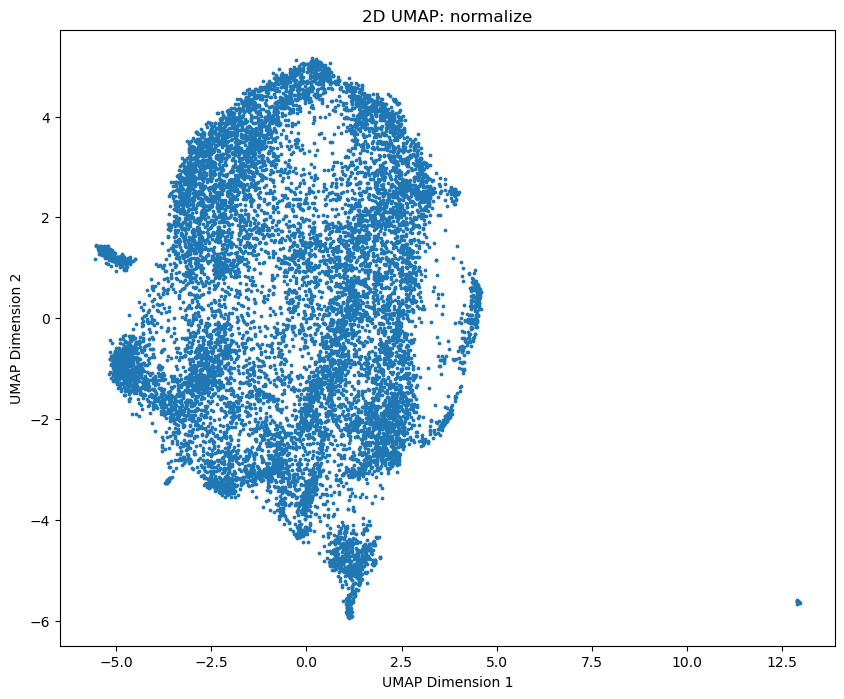

In [143]:
#Implement UMAP

def umapTest(data, name=None, neighbors=100, display=True):
    dim_reducer = UMAP(n_neighbors=neighbors, n_components=2, random_state=42)

    embed_UMAP = dim_reducer.fit_transform(data)
    if display:
        plt.figure(figsize=(10,8))
        scatter = plt.scatter(embed_UMAP[:, 0], embed_UMAP[:, 1], cmap='Spectral', s=3)
        plt.title(f'2D UMAP: {name}' if name else '2D UMAP')
        plt.xlabel("UMAP Dimension 1")
        plt.ylabel("UMAP Dimension 2")
        plt.show()
    return embed_UMAP

embed_U = umapTest(current_embeddings, current_name)

In [124]:

# Get the user's favorite book and genre
#fav_book = input('Enter your favorite book name: ')  # Example: "Rage of Angels"
#fav_genre = input('What is your favorite genre: ')  # Example: "Thriller"


def user_input(book, genre):
    # Combine the favorite book and genre to form a user input
    usr_input = book + ": " + genre


    # Tokenize user input and generate embedding
    tokenized_input = tokenizer(
        usr_input,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to('cuda')
    return tokenized_input

#user_tokens = user_input(fav_book, fav_genre)

In [ ]:
def get_answer(tokens):
    user_embedding = book_model(**tokens)
    hidden_states = user_embedding.last_hidden_state  # Shape: (batch_size, seq_len, hidden_dim)
    usr_embeddings = hidden_states.mean(dim=1)  # Mean pooling across tokens
    ue = usr_embeddings.detach().cpu().numpy()
    norm_ue = np.vstack(ue)

    norm_ue = normalize(norm_ue)

    # Calculate cosine similarity between the user's input embedding and all book embeddings
    similarity_scores = cosine_similarity(norm_ue, current_embeddings).flatten()

    # Get the top 5 most similar books
    # top_indices = similarity_scores.argsort()[-5:][::-1]  # Indices of the top 5 books
    df["Similarity"] = similarity_scores.T
    

In [128]:
def llm_routine():
    book = input('Enter your favorite book name: ')  # Example: "Rage of Angels"
    genre = input('What is your favorite genre: ')  # Example: "Thriller"
    print(f'Book: {book}, Genre: {genre}')
    get_answer(user_input(book, genre))
    print('Recommended')
    recommended_books = df.sort_values(by="Similarity", ascending=False).head(5)
    display(recommended_books[["Title", "Category", "Similarity"]])
    print('Not Good')
    not_good_books = df.sort_values(by="Similarity", ascending=False).tail(5)
    display(not_good_books[["Title", "Category", "Similarity"]])

In [144]:
for i in range(1,4):
    print(f'Try {i}')
    llm_routine()

Try 1
Book: FireFighter Actions, Genre: Nonfiction


array([0.6197225 , 0.6090456 , 0.5841074 , ..., 0.5153506 , 0.617789  ,
       0.58980685], dtype=float32)

Recommended


,Title,Category,Similarity
89574,Medal of Honor: Portraits of Valor Beyond the ...,"Biography & Autobiography , Military",0.703173
99917,If I Had a Hammer: Building Homes and Hope wit...,"Juvenile Nonfiction , House & Home",0.699907
86542,Medal of Honor: Portraits of Valor Beyond the ...,"History , Military , Veterans",0.697188
98367,How To Reach And Teach Children with ADD / ADH...,"Education , Special Education",0.695152
85377,Obama: A Promise of Change,"Young Adult Nonfiction , People & Places",0.691887


Not Good


,Title,Category,Similarity
83167,Wuthering Heights (Barnes & Noble Classics),"Fiction , Classics",0.443254
93454,Pest Control,"Fiction , Romance , Contemporary",0.430995
92417,Las Huellas Secretas (Spanish Edition),"Juvenile Fiction , People & Places , United St...",0.421189
99057,Tan veloz como el deseo: Una Novela (Spanish E...,"Fiction , Literary",0.418434
97690,I Am a Firefighter (I Am A...(Barrons Educatio...,"Juvenile Nonfiction , Careers",0.316631


Try 2
Book: World War II Actions, Genre: History


array([0.29764086, 0.35033628, 0.33176523, ..., 0.33875394, 0.32537758,
       0.3179251 ], dtype=float32)

Recommended


,Title,Category,Similarity
96750,The Civil War Day By Day,"History , United States , Civil War Period (18...",0.513695
98429,Heroes: U.S. Marine Corps Medal of Honor Winners,"History , Military",0.500336
89271,The Civil War Book Of Lists: Over 300 Lists Fr...,"History , United States , Civil War Period (18...",0.497114
92603,Churchill's Secret Agent: A Novel Based on a T...,"Fiction , War & Military",0.494612
100115,World War II,"History , Military , World War II",0.491651


Not Good


,Title,Category,Similarity
88774,YOGA FOR COMMON AILMENTS,"Health & Fitness , Yoga",0.247879
88069,Mister Pasta's Healthy Pasta Cookbook: More Th...,"Cooking , Specific Ingredients , Pasta",0.246492
90308,"Smoothies and Other Blended Drinks (Ryland, Pe...","Cooking , Beverages , Juices & Smoothies",0.245092
92797,Fabulous No Guilt Desserts (Prevention Magazin...,"Cooking , Courses & Dishes , Desserts",0.241548
97690,I Am a Firefighter (I Am A...(Barrons Educatio...,"Juvenile Nonfiction , Careers",0.208719


Try 3
Book: Disney Cooking, Genre: Cooking


array([0.611001  , 0.48835996, 0.47554952, ..., 0.42696142, 0.57717437,
       0.513161  ], dtype=float32)

Recommended


,Title,Category,Similarity
87639,Top Chef: The Quickfire Cookbook,"Cooking , Courses & Dishes",0.652363
95803,Country Cakes: A Homestyle Treasury,Cooking,0.641261
98019,Quick Short Recipe Cookbook,Cooking,0.634397
87548,Food & Wine Best of the Best Cookbook Recipes,Cooking,0.633516
84927,Cookie Sensations: Creative Designs for Every ...,"Cooking , Courses & Dishes , Cookies",0.631863


Not Good


,Title,Category,Similarity
83167,Wuthering Heights (Barnes & Noble Classics),"Fiction , Classics",0.299098
92417,Las Huellas Secretas (Spanish Edition),"Juvenile Fiction , People & Places , United St...",0.292105
93454,Pest Control,"Fiction , Romance , Contemporary",0.289128
99057,Tan veloz como el deseo: Una Novela (Spanish E...,"Fiction , Literary",0.286496
97690,I Am a Firefighter (I Am A...(Barrons Educatio...,"Juvenile Nonfiction , Careers",0.274655
